<a href="https://colab.research.google.com/github/andreavittino/colab_notebooks/blob/main/BreastCancer_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
from sklearn.datasets import load_breast_cancer
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
cancer = load_breast_cancer()
cancer.target_names

array(['malignant', 'benign'], dtype='<U9')

In [3]:
data_df = pd.DataFrame(data=cancer.data,columns=cancer.feature_names)
target_df = pd.Series(cancer.target,name='cancer_type')
df = pd.concat([data_df,target_df],axis=1)
print(df.head())
print(df.info())
print(df.describe())
print(df['cancer_type'].value_counts())

   mean radius  mean texture  ...  worst fractal dimension  cancer_type
0        17.99         10.38  ...                  0.11890            0
1        20.57         17.77  ...                  0.08902            0
2        19.69         21.25  ...                  0.08758            0
3        11.42         20.38  ...                  0.17300            0
4        20.29         14.34  ...                  0.07678            0

[5 rows x 31 columns]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   mean radius              569 non-null    float64
 1   mean texture             569 non-null    float64
 2   mean perimeter           569 non-null    float64
 3   mean area                569 non-null    float64
 4   mean smoothness          569 non-null    float64
 5   mean compactness         569 non-null    float64
 6   mea

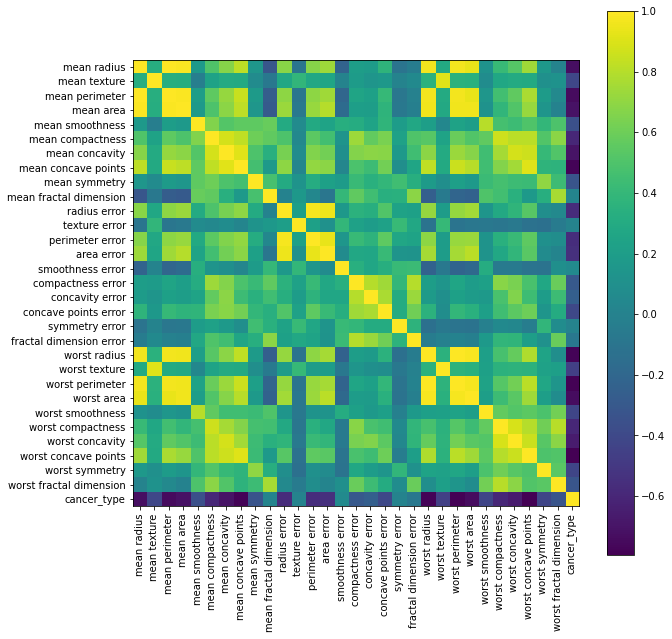

In [4]:
plt.figure(figsize=(10,10))
plt.imshow(df.corr())
plt.colorbar()
plt.xticks(range(31),df.columns,rotation = 90)
plt.yticks(range(31),df.columns)
plt.show()

# Using a random forest

We start with the default parameters

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [6]:
rfc = RandomForestClassifier(n_estimators=200,random_state=42)

In [7]:
X = df.drop('cancer_type',axis=1)
y = df['cancer_type']

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=42)

In [9]:
rfc.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

ROC curve

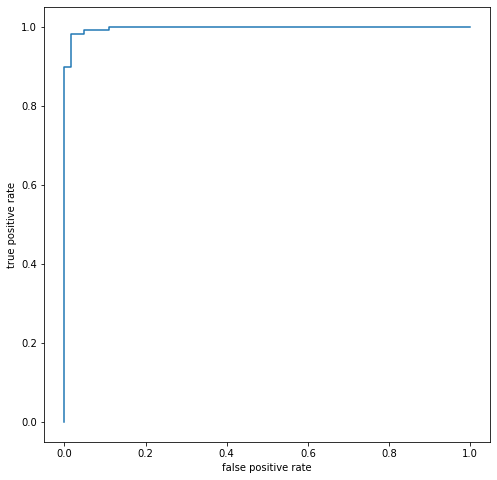

In [10]:
y_pred = rfc.predict(X_test)
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_test, rfc.predict_proba(X_test)[:,1])
fig = plt.figure(figsize=(8,8))
plt.plot(fpr,tpr)
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.show()

In [11]:
rfc.score(X_test,y_test)

0.9707602339181286

Confusion matrix

In [12]:
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[ 59   4]
 [  1 107]]
              precision    recall  f1-score   support

           0       0.98      0.94      0.96        63
           1       0.96      0.99      0.98       108

    accuracy                           0.97       171
   macro avg       0.97      0.96      0.97       171
weighted avg       0.97      0.97      0.97       171



In [13]:
df_feature_imp = pd.DataFrame({'feature ': X.columns,'importance': rfc.feature_importances_})
print(df_feature_imp.sort_values(by='importance',ascending=False).head(10))

                feature   importance
7    mean concave points    0.133574
27  worst concave points    0.124374
22       worst perimeter    0.116470
23            worst area    0.115029
20          worst radius    0.069335
6         mean concavity    0.066519
2         mean perimeter    0.050585
3              mean area    0.046917
26       worst concavity    0.041539
0            mean radius    0.034793


We now use cross-validation to do some hyperparameter tuning


In [14]:
from sklearn.model_selection import RandomizedSearchCV
param_dist = {"n_estimators" : [50,100,200], 'max_depth' : [None, 8, 16], 'max_features' : [8,16,30]}
rs = RandomizedSearchCV(rfc,param_dist,cv=5,random_state=42)

In [15]:
rs.fit(X_train,y_train)

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [16]:
rfc_best = rs.best_estimator_

In [17]:
y_pred_best = rfc_best.predict(X_test)
print(rfc_best.score(X_test,y_test))

0.9766081871345029


In [18]:
print(confusion_matrix(y_test,y_pred_best))
print(classification_report(y_test,y_pred_best))

[[ 60   3]
 [  1 107]]
              precision    recall  f1-score   support

           0       0.98      0.95      0.97        63
           1       0.97      0.99      0.98       108

    accuracy                           0.98       171
   macro avg       0.98      0.97      0.97       171
weighted avg       0.98      0.98      0.98       171

